# Directory

```bash
├── data
│   ├── out_data.zip
│   ├── rf_data
│   ├── water_data
├── out
├── Imputaton-Submission.ipynb
└── Project-Submission.ipynb
``` 

# 외부 데이터 링크
https://drive.google.com/file/d/1it6J1ZKj8IzpWBELZhjJZdQC5f5L_5Wm/view?usp=sharing 

# OS
- Ubuntu
- Intel i9 10900
- NVIDIA GeForce RTX 3080
- Memory 64GB

In [1]:
import pandas as pd
import numpy as np

from glob import glob
from tqdm import tqdm
from scipy import interpolate

#visualization
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns

import sys
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import Lasso, Ridge
from datetime import datetime, timedelta

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor , AdaBoostRegressor, StackingRegressor, BaggingRegressor, VotingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.base import clone
import sklearn

import random
import os
import zipfile
import warnings
warnings.filterwarnings('ignore')


# ANN module
import torch
from torch import nn, optim                           # torch 에서 제공하는 신경망 기술, 손실함수, 최적화를 할 수 있는 함수들을 불러온다.
from torch.utils.data import DataLoader, Dataset      # 데이터를 모델에 사용할 수 있게 정리해주는 라이브러리.
import torch.nn.functional as F                       # torch 내의 세부적인 기능을 불러옴.



In [2]:
SEED = 123
def seed_everything(seed=123):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
seed_everything(SEED)

In [3]:
print('numpy verison :', np.__version__)
print('pandas version :', pd.__version__)
print('torch version :', torch.__version__)
print('sklearn verison :', sklearn.__version__)

numpy verison : 1.19.5
pandas version : 1.1.5
torch version : 1.8.1+cu111
sklearn verison : 0.24.2


In [4]:
fantasy_zip = zipfile.ZipFile('./data/out_data.zip')
fantasy_zip.extractall('./data/out_data')
 
fantasy_zip.close()

In [5]:
w_list = sorted(glob("./data/water_data/*.csv"))
r_list = sorted(glob("./data/rf_data/*.csv"))

ro_list = sorted(glob("./data/out_data/rf_out_data/*"))
wo_list = sorted(glob("./data/out_data/wl_out_data/*"))

In [6]:
data_list = []
for k in range(len(w_list)):
    data_w = pd.read_csv(w_list[k])
    data_w = data_w.drop('fw_1018680', axis=1)
    data_w['time'] = data_w.index
#     print(data_w.isna().sum())
    
    data_r = pd.read_csv(r_list[k])
    data_r = data_r.drop('ymdhm', axis=1)
    data_r['year'] = k
    
    wos = []
    for l in range(len(wo_list)):
        wo = pd.read_csv(sorted(glob(wo_list[l]+"/*.csv"))[k])
        wo = wo.replace(r'^\s*$', np.nan, regex=True)
        wo['wl'] = wo['wl'].astype('float')
        wo['fw'] = wo['fw'].astype('float')
        wo = pd.DataFrame(wo.iloc[:,:2])
        wo.columns = ['fw_out_'+wo_list[l][-7:], 'wl_out_'+wo_list[l][-7:]]
        wos.append(wo)
    
    ro = pd.read_csv(sorted(glob(ro_list[0]+"/*.csv"))[k])
    ro = pd.DataFrame(ro.iloc[:,0])
    ro = ro.replace(r'^\s*$', np.nan, regex=True)
    ro['rf'] = ro['rf'].astype('float')
    ro.columns = ['rf_out_'+ro_list[0][-7:]]    
    
    data = pd.concat([data_w, data_r, ro] + wos, axis=1)
#     print(data.isna().sum())
    data_list.append(data)
    print(data['ymdhm'][0])
    print(len(data))
data = pd.concat(data_list).reset_index(drop=True)

2012-05-01 00:00
26496
2013-05-01 00:00
26496
2014-05-01 00:00
26496
2015-05-01 00:00
26496
2016-05-01 00:00
26496
2017-05-01 00:00
26496
2018-05-01 00:00
26496
2019-05-01 00:00
26496
2020-05-01 00:00
26496
2021-05-01 00:00
26496
2022-05-01 00:00
26496


## fw_1018658, fw_1018662 결측 대체: MLP 이용

In [7]:
data = data.iloc[:(data[data['ymdhm']=="2022-07-18 23:50"].index[0]+1)]

In [8]:
y = 4
dat = data[data['year'] > y].reset_index(drop=True)
dat

,ymdhm,swl,inf,sfw,ecpc,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,...,fw_out_1018680,wl_out_1018680,fw_out_1018683,wl_out_1018683,fw_out_1018697,wl_out_1018697,fw_out_1019630,wl_out_1019630,fw_out_1019675,wl_out_1019675
0,2017-05-01 00:00,25.280,11.00,221.70,22.30,114.00,342.0,330.7,622.73,309.2,...,NaN,3.16,-944.41,0.97,3.42,0.96,805.46,2.15,NaN,2.77
1,2017-05-01 00:10,25.259,16.60,220.93,23.07,119.90,326.0,333.7,647.71,314.2,...,NaN,3.21,-523.16,1.05,3.42,0.96,748.09,2.11,NaN,2.66
2,2017-05-01 00:20,25.256,16.61,220.83,23.17,119.91,310.0,336.7,673.20,317.2,...,NaN,3.24,-131.32,1.08,3.42,0.96,692.88,2.07,NaN,2.55
3,2017-05-01 00:30,25.250,0.00,220.57,23.43,119.95,295.0,337.7,681.80,317.2,...,NaN,3.24,157.80,1.09,3.42,0.96,639.83,2.03,NaN,2.46
4,2017-05-01 00:40,25.245,0.00,220.40,23.61,119.97,280.0,336.7,673.20,317.2,...,NaN,3.24,403.27,1.09,3.42,0.96,614.11,2.01,NaN,2.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143851,2022-07-18 23:10,25.040,259.23,212.86,31.14,259.23,510.0,0.0,319.84,0.0,...,NaN,3.02,-456.41,0.92,6.64,0.85,974.40,2.26,NaN,3.69
143852,2022-07-18 23:20,25.040,260.46,212.86,31.14,260.46,492.0,0.0,314.01,0.0,...,NaN,3.10,-717.30,0.97,6.64,0.85,1006.88,2.28,NaN,3.63
143853,2022-07-18 23:30,25.040,259.37,212.86,31.14,259.37,475.0,0.0,387.55,0.0,...,NaN,3.14,-843.37,1.02,6.64,0.85,1039.90,2.30,NaN,3.52
143854,2022-07-18 23:40,25.040,259.13,212.86,31.14,259.13,458.0,0.0,454.91,0.0,...,NaN,3.18,-1023.37,1.07,6.64,0.85,1073.46,2.32,NaN,3.38


In [9]:
train_data = data.iloc[:(data[data['ymdhm']=="2022-05-31 23:50"].index[0]+1)]
test_data = data.iloc[(data[data['ymdhm']=="2022-05-31 23:50"].index[0]+1):]

In [10]:
name_list = [('1018662', 'CD'), ('1018680', 'JS'), ('1018683', 'HG') , ('1019630', 'HJ'), ('1018610', 'PD'), ('1018640', 'GJ'), ('1018658', 'DC'), ('1018675', 'JR'), ('1018697', 'OG'), ('1019675', 'GP')]

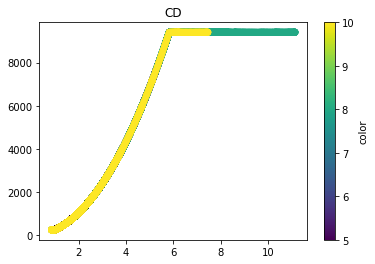

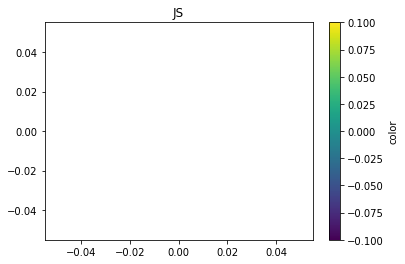

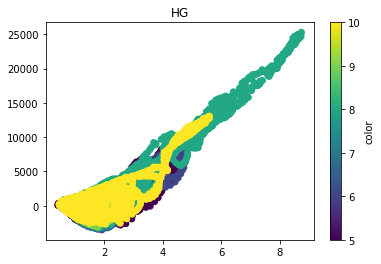

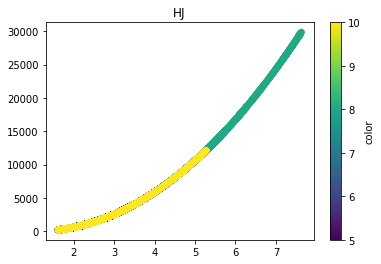

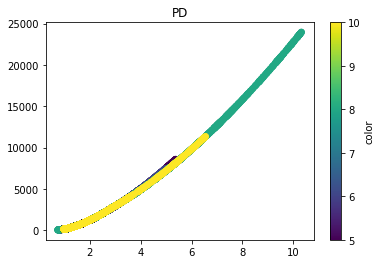

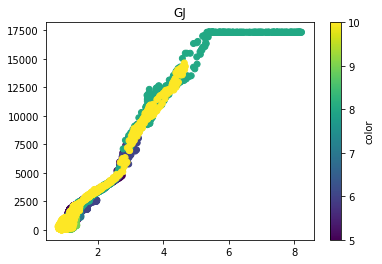

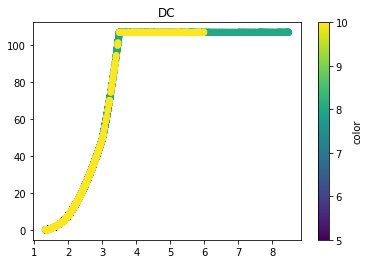

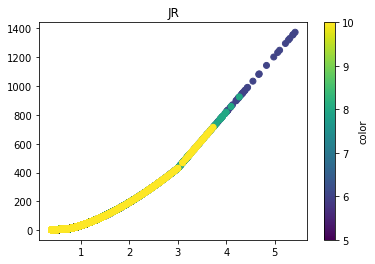

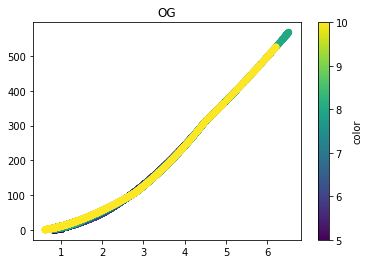

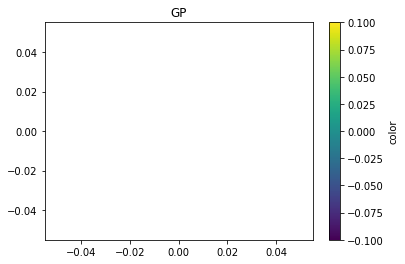

In [11]:
ll = []
for i in range(len(name_list)):
    tt = dat.copy()
    try:
        z = tt[['wl_out_'+name_list[i][0], 'fw_out_'+name_list[i][0]]].dropna()
        x_min, x_max = np.min(z['wl_out_'+name_list[i][0]]), np.max(z['wl_out_'+name_list[i][0]])
        y_min, y_max = np.min(z['fw_out_'+name_list[i][0]]), np.max(z['fw_out_'+name_list[i][0]])
        ll.append((name_list[i][0], x_min, x_max, y_min, y_max))
        tt['fw_out_'+name_list[i][0]][tt['wl_out_'+name_list[i][0]] > x_max] = y_max
        tt['fw_out_'+name_list[i][0]][tt['wl_out_'+name_list[i][0]] < x_min] = y_min
        plt.scatter(tt['wl_out_'+name_list[i][0]], tt['fw_out_'+name_list[i][0]], c = tt['year'])

        plt.colorbar(label='color')
        plt.title(name_list[i][1])
        plt.show()
    except:    
        print('ERROR: ', name_list[i][1])

In [12]:
train_data = data.iloc[:(data[data['ymdhm']=="2022-05-31 23:50"].index[0]+1)]
test_data = data.iloc[(data[data['ymdhm']=="2022-05-31 23:50"].index[0]+1):]

In [13]:
# torch의 Dataset 을 상속.
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

In [14]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(1, 1024, bias=True) # 입력층(1) -> 은닉층1(50)으로 가는 연산
        self.fc2 = nn.Linear(1024, 1024, bias=True) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
        self.fc3 = nn.Linear(1024, 1, bias=True) # 은닉층2(30) -> 출력층(1)으로 가는 연산
        self.dropout = nn.Dropout(0.2) # 연산이 될 때마다 20%의 비율로 랜덤하게 노드를 없앤다.

    def forward(self, x): # 모델 연산의 순서를 정의
        x = F.relu(self.fc1(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
        x = self.dropout(F.relu(self.fc2(x))) # 은닉층2에서 드랍아웃을 적용한다.(즉, 30개의 20%인 6개의 노드가 계산에서 제외된다.)
        x = F.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
      
        return x
    

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
def imputation(dat_tr, dat, name):
    tt = dat_tr[['fw_out_'+name, 'wl_out_'+name]].dropna()
    Y = tt['fw_out_'+name]
    X = tt['wl_out_'+name]
    
    
    # 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.
    # 기준으로 잡은 논문이 전체 데이터를 50%, 50%로 나눴기 때문에 test size를 0.5로 설정한다.
    X_train, X_test, Y_train, Y_test = train_test_split(np.array(X), np.array(Y), test_size=0.5)

    # 학습 데이터, 시험 데이터 배치 형태로 구축하기
    trainsets = TensorData(X_train, Y_train)
    trainloader = torch.utils.data.DataLoader(trainsets, batch_size=np.int(len(X_train)*0.01), shuffle=True)

    testsets = TensorData(X_test, Y_test)
    testloader = torch.utils.data.DataLoader(testsets, batch_size=np.int(len(X_test)*0.01), shuffle=False)

    model = Regressor().to(device)
    criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    loss_ = [] # loss를 저장할 리스트.
    test_loss_ = []
    n = len(trainloader)

    for epoch in tqdm(range(1000)):

        running_loss = 0.0 # 한 에폭이 돌 때 그안에서 배치마다 loss가 나온다. 즉 한번 학습할 때 그렇게 쪼개지면서 loss가 다 나오니 MSE를 구하기 위해서 사용한다.

        for i, data in enumerate(trainloader): # 무작위로 섞인 32개의 데이터가 담긴 배치가 하나씩 들어온다.

            inputs, values = data # data에는 X, Y가 들어있다.
            inputs = inputs.reshape(-1,1).to(device)
            values = values.reshape(-1,1).to(device)


            optimizer.zero_grad() # 최적화 초기화.

            outputs = model(inputs) # 모델에 입력값을 넣어 예측값을 산출한다.
            loss = criterion(outputs, values) # 손실함수를 계산. error 계산.
            loss.backward() # 손실 함수를 기준으로 역전파를 설정한다.
            optimizer.step() # 역전파를 진행하고 가중치를 업데이트한다.

            running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.

        loss_.append(running_loss/n) # MSE(Mean Squared Error) 계산
    #     print(running_loss/n)

        with torch.no_grad():
            model.eval()
            test_loss = 0.0

            for i, data in enumerate(testloader):
                inputs, values = data # data에는 X, Y가 들어있다.
                inputs = inputs.reshape(-1,1).to(device)
                values = values.reshape(-1,1).to(device)

                outputs = model(inputs)
                test_loss += criterion(outputs, values).item()

        test_loss_.append(test_loss/n) # MSE(Mean Squared Error) 계산
        if epoch % 500 == 0:
            plt.scatter(X, model(torch.Tensor(np.array(X)).reshape(-1,1).to(device)).cpu().detach().numpy())
            plt.scatter(X, Y)
            plt.show()
        
    print(np.min(test_loss_))
    plt.plot(loss_)
    plt.plot(test_loss_)
    plt.show()

    
    impt = dat[['fw_out_'+name, 'wl_out_'+name]]
    impX = dat['wl_out_'+name]
    impY = dat['fw_out_'+name]
    
    
    X = np.array(impX[(-impX.isna()) & (impY.isna())])
    Y_imp = model(torch.Tensor(X).reshape(-1,1).to(device)).cpu().detach().numpy()

    
    impY[(-impX.isna()) & (impY.isna())] = Y_imp.reshape(-1)
    
    return impY

In [17]:
x_min, x_max, y_min, y_max = ll[6][1:]

In [18]:
name = '1018658'

In [19]:
data['fw_out_'+name][data['wl_out_'+name] > x_max] = y_max
data['fw_out_'+name][data['wl_out_'+name] < x_min] = y_min

  0%|          | 0/1000 [00:00<?, ?it/s]

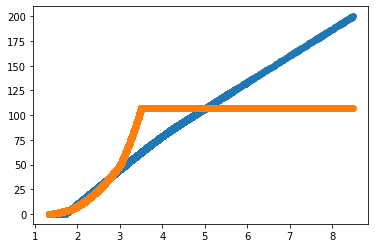

 50%|█████     | 500/1000 [04:02<03:57,  2.10it/s]

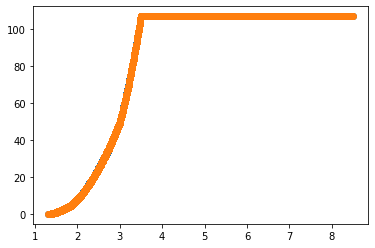

100%|██████████| 1000/1000 [08:05<00:00,  2.06it/s]

0.00016226258457668292


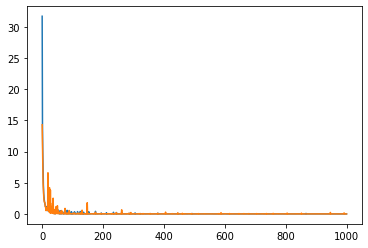

In [20]:
data['fw_out_'+name] = imputation(train_data, data, name)

In [21]:
x_min, x_max, y_min, y_max = ll[0][1:]

In [22]:
name = '1018662'

In [23]:
data['fw_out_'+name][data['wl_out_'+name] > x_max] = y_max
data['fw_out_'+name][data['wl_out_'+name] < x_min] = y_min

  0%|          | 0/1000 [00:00<?, ?it/s]

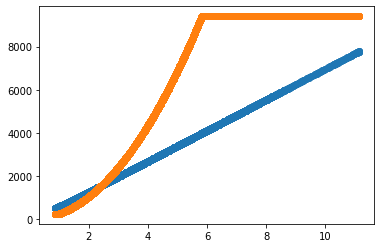

 50%|█████     | 500/1000 [07:41<07:36,  1.10it/s]

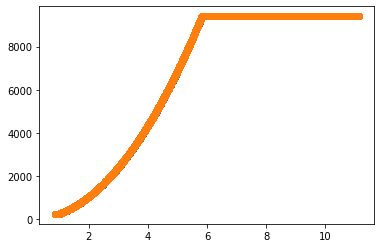

100%|██████████| 1000/1000 [15:25<00:00,  1.08it/s]

0.20177049573400233


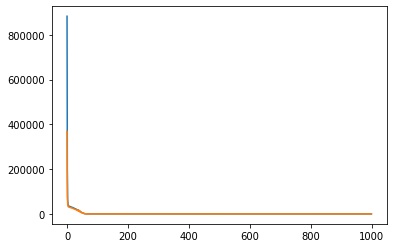

In [24]:
data['fw_out_'+name]  = imputation(train_data, data, name)

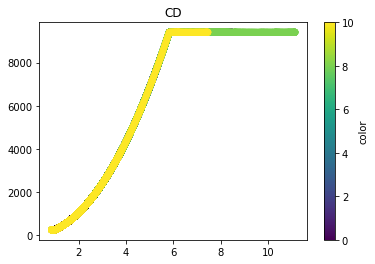

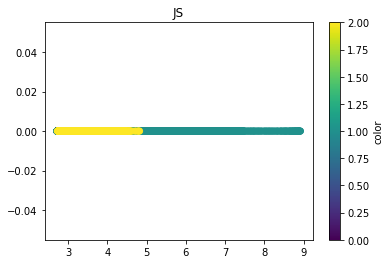

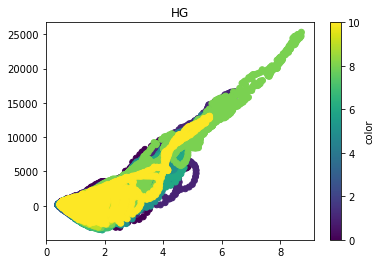

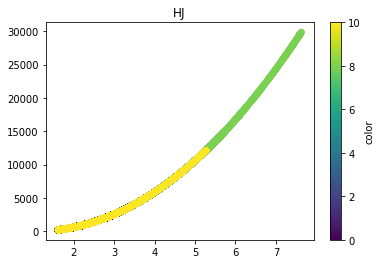

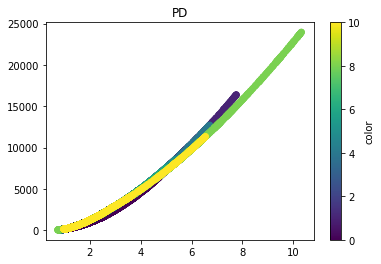

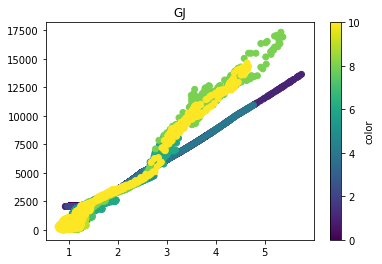

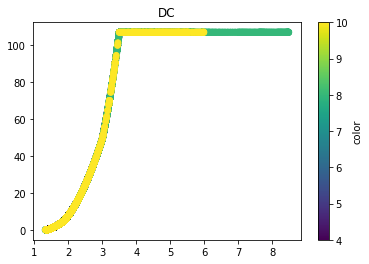

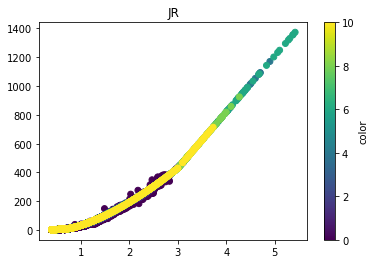

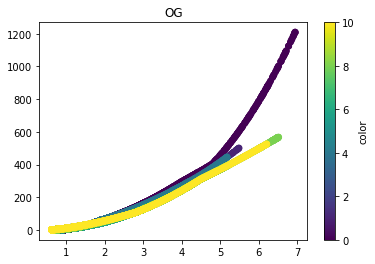

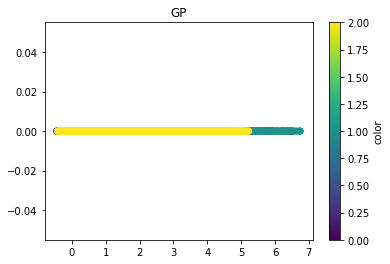

In [25]:

for i in range(len(name_list)):
    tt = data.copy()
#     tt['wl_out_1018662'].loc[tt['fw_out_1018662'] == np.max(tt['fw_out_1018662'])] = np.min(tt['wl_out_1018662'].loc[tt['fw_out_1018662'] == np.max(tt['fw_out_1018662'])])
    try:
        plt.scatter(tt['wl_out_'+name_list[i][0]], tt['fw_out_'+name_list[i][0]], c = tt['year'])
        plt.colorbar(label='color')
        plt.title(name_list[i][1])
        plt.show()
    except:    
        print('ERROR: ', name_list[i][1])

## swl, inf, sfw, ecpc, tototf 결측 대체: Moving Average 이용

In [26]:
train_data = data.iloc[:(data[data['ymdhm']=="2022-05-31 23:50"].index[0]+1)]
test_data = data.iloc[(data[data['ymdhm']=="2022-05-31 23:50"].index[0]+1):]

In [27]:
Xc = train_data.columns.drop(['ymdhm', 'time', 'year', 'wl_1018662', 'fw_1018662', 'wl_1018680', 'wl_1018683', 'fw_1018683', 'wl_1019630', 'fw_1019630', 'fw_out_1018680', 'fw_out_1019675'])

In [28]:
test_data[Xc]

,swl,inf,sfw,ecpc,tototf,tide_level,rf_10184100,rf_10184110,rf_10184140,rf_out_0194010,...,fw_out_1018675,wl_out_1018675,wl_out_1018680,fw_out_1018683,wl_out_1018683,fw_out_1018697,wl_out_1018697,fw_out_1019630,wl_out_1019630,wl_out_1019675
269424,25.19,140.60,218.36,25.64,140.60,162.0,0.0,0.0,0.0,0.0,...,2.37,0.43,2.83,8.23,0.67,3.23,0.71,471.08,1.89,1.03
269425,25.19,140.78,218.36,25.64,140.78,151.0,0.0,0.0,0.0,0.0,...,2.37,0.43,2.84,28.82,0.67,3.23,0.71,449.12,1.87,0.96
269426,25.20,755.90,218.73,25.27,140.90,141.0,0.0,0.0,0.0,0.0,...,2.37,0.43,2.84,12.35,0.67,3.23,0.71,417.17,1.84,0.89
269427,25.19,0.00,218.36,25.64,140.94,130.0,0.0,0.0,0.0,0.0,...,2.37,0.43,2.84,53.52,0.67,3.23,0.71,386.43,1.81,0.82
269428,25.19,140.63,218.36,25.64,140.63,120.0,0.0,0.0,0.0,0.0,...,2.37,0.43,2.85,107.04,0.67,3.23,0.71,366.60,1.79,0.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276331,25.04,259.23,212.86,31.14,259.23,510.0,0.0,0.0,0.0,0.0,...,8.33,0.68,3.02,-456.41,0.92,6.64,0.85,974.40,2.26,3.69
276332,25.04,260.46,212.86,31.14,260.46,492.0,0.0,0.0,0.0,0.0,...,8.33,0.68,3.10,-717.30,0.97,6.64,0.85,1006.88,2.28,3.63
276333,25.04,259.37,212.86,31.14,259.37,475.0,0.0,0.0,0.0,0.0,...,8.33,0.68,3.14,-843.37,1.02,6.64,0.85,1039.90,2.30,3.52
276334,25.04,259.13,212.86,31.14,259.13,458.0,0.0,0.0,0.0,0.0,...,8.33,0.68,3.18,-1023.37,1.07,6.64,0.85,1073.46,2.32,3.38


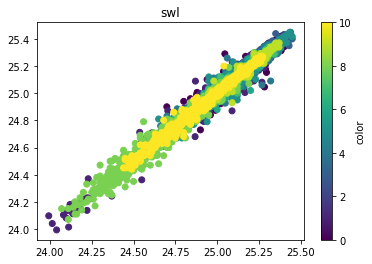

826


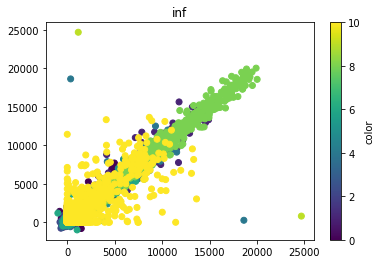

744


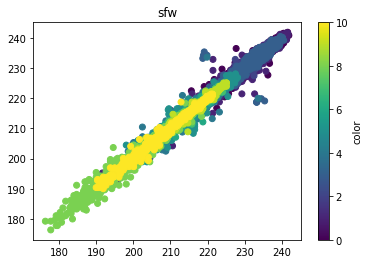

826


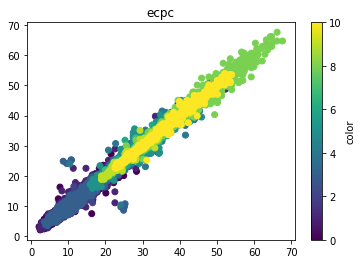

826


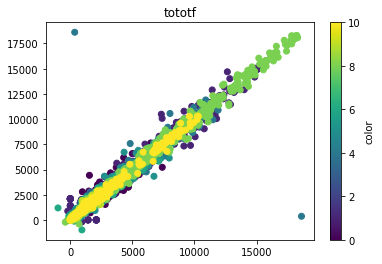

745


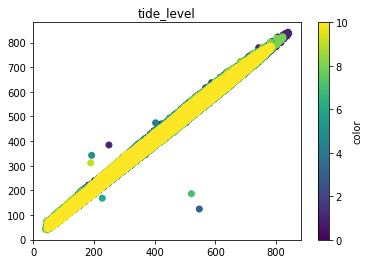

4927


In [29]:
imp_list = ['swl','inf','sfw','ecpc','tototf','tide_level']
for i in range(len(imp_list)):
    tt = data.copy()
    if imp_list[i] == 'swl':
        tt[imp_list[i]][tt[imp_list[i]]==0] = np.nan
    elif imp_list[i] == 'inf':
        tt[imp_list[i]][tt[imp_list[i]] == np.max(tt[imp_list[i]])] = np.nan
    elif imp_list[i] == 'sfw':
        tt[imp_list[i]][tt[imp_list[i]]< 10] = np.nan
    elif imp_list[i] == 'ecpc':
        tt[imp_list[i]][tt[imp_list[i]]> 200] = np.nan   
    elif imp_list[i] == 'tototf':
        tt[imp_list[i]][tt[imp_list[i]]> 24800] = np.nan   
        
    try:
        plt.scatter(tt[imp_list[i]].shift(1), tt[imp_list[i]], c = tt['year'])
        plt.colorbar(label='color')
        plt.title(imp_list[i])
        plt.show()
    except:    
        print('ERROR: ', name_list[i][1])
        
    print(tt[imp_list[i]].isna().sum())

In [30]:
imp_list = ['swl','inf','sfw','ecpc','tototf']
for i in range(len(imp_list)):
    if imp_list[i] == 'swl':
        train_data[imp_list[i]][train_data[imp_list[i]]==0] = np.nan
    elif imp_list[i] == 'inf':
        train_data[imp_list[i]][train_data[imp_list[i]]== np.max(tt[imp_list[i]])] = np.nan
    elif imp_list[i] == 'sfw':
        train_data[imp_list[i]][train_data[imp_list[i]]< 10] = np.nan
    elif imp_list[i] == 'ecpc':
        train_data[imp_list[i]][train_data[imp_list[i]]> 200] = np.nan   
    elif imp_list[i] == 'tototf':
        train_data[imp_list[i]][train_data[imp_list[i]] == np.max(tt[imp_list[i]])] = np.nan   

In [31]:
X_columns = Xc.drop(['swl', 'inf','sfw','ecpc','tototf'])
y_columns = ['swl', 'inf','sfw','ecpc','tototf']
# ,'inf','sfw','ecpc','tototf'

In [32]:
lag = 3
td = train_data[Xc]
col_list = []
for s in range(1,lag+1):
    for x_col in y_columns:
        td[x_col + '_lag_' + str(s)] = td[x_col].shift(s)
        col_list.append(x_col + '_lag_' + str(s))
        
for s in range(1,lag+1):
    for x_col in X_columns:
        td[x_col + '_lag_' + str(s)] = td[x_col].shift(s)
        col_list.append(x_col + '_lag_' + str(s))

In [33]:
nan_indices =np.random.choice(len(train_data)-1, 1000, replace=False)
nan_indices = nan_indices[nan_indices > lag]

In [34]:
for cn in range(len(y_columns)):
    TT = train_data[y_columns]

    y_val = TT[y_columns[cn]].iloc[nan_indices]
    TT[y_columns[cn]].iloc[nan_indices] = np.nan

    cnt = 0

    for idx in nan_indices:
        TT[y_columns[cn]].iloc[idx] = np.mean(TT[y_columns[cn]][(idx-lag):idx])

    y_pred = TT.iloc[nan_indices,cn]
    iii = -y_val.isna() & -y_pred.isna()
    y_vals = np.array(y_val[iii])
    y_preds = np.array(y_pred[iii])
    print(y_columns[cn],": ",mean_squared_error(y_vals, y_preds)**0.5)

swl :  0.010579204329641238
inf :  139.6737546143978
sfw :  0.39926307666326527
ecpc :  0.3992117417499681
tototf :  62.24380273859833


In [35]:
for col in y_columns:
    indices = data[pd.isnull(data[col])].index
    col_num = np.where(data.columns == col)[0][0]
    print("NaN num:", len(indices))
    for idx in  tqdm(indices):
        data.iloc[idx, col_num] = np.mean(data[col][(idx-lag):idx])


 25%|██▌       | 207/826 [00:00<00:00, 2060.31it/s]

NaN num: 826


 27%|██▋       | 203/744 [00:00<00:00, 2025.59it/s]

NaN num: 744


 25%|██▍       | 206/826 [00:00<00:00, 2052.68it/s]

NaN num: 826


 25%|██▌       | 207/826 [00:00<00:00, 2061.19it/s]

NaN num: 826


 28%|██▊       | 208/744 [00:00<00:00, 2072.93it/s]

NaN num: 744


100%|██████████| 744/744 [00:00<00:00, 2069.79it/s]


## tide level 결측 대체: LightGBM 이용

In [36]:
train_data = data.iloc[:(data[data['ymdhm']=="2022-05-31 23:50"].index[0]+1)]
test_data = data.iloc[(data[data['ymdhm']=="2022-05-31 23:50"].index[0]+1):]

In [37]:
X_columns = Xc.drop(['inf','tototf', 'tide_level'])
y_columns = ['tide_level']


In [38]:
tt = train_data.copy()


col_list = list(X_columns)
for x_col in X_columns:
    for s in range(1, lag+1):
        tt[x_col+'_lag_'+str(s)] = tt[x_col].shift(s)
        col_list.append(x_col+'_lag_'+str(s))
        

for s in range(1, lag+1):
    tt[y_columns[0]+'_lag_'+str(s)] = tt[y_columns[0]].shift(s)
    col_list.append(y_columns[0]+'_lag_'+str(s))
        
tt = tt[col_list+y_columns].dropna()

In [39]:
Y = tt[y_columns]
X = tt[col_list]

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(X), np.array(Y), test_size=0.2)

model = LGBMRegressor(n_estimators = 1000, random_state=1234)
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

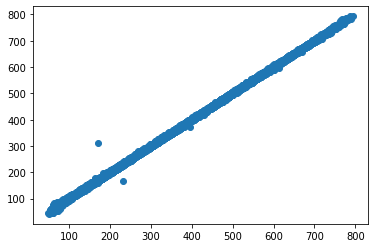

In [41]:
plt.scatter(Y_pred,Y_test)

In [42]:
mean_squared_error(Y_test, Y_pred) ** 0.5

2.270086508624858

In [43]:
tt = train_data[list(X_columns)+list(y_columns)].reset_index(drop=True)
indices = tt[tt[y_columns].T.isna().any()].index

In [44]:
for idx in tqdm(indices):
    te = tt.iloc[(idx-lag):(idx+1)]
#     print(te)
    
    col_list = list(X_columns)
    for x_col in X_columns:
        for s in range(1, lag+1):
            te[x_col+'_lag_'+str(s)] = te[x_col].shift(s)
            col_list.append(x_col+'_lag_'+str(s))
            
    for s in range(1, lag+1):
        te[y_columns[0]+'_lag_'+str(s)] = te[y_columns[0]].shift(s)
        col_list.append(y_columns[0]+'_lag_'+str(s))
    
    
    train_data['tide_level'].iloc[idx] = model.predict(np.array(te[col_list].iloc[-1]).reshape(1,-1))
    

100%|██████████| 4923/4923 [02:08<00:00, 38.29it/s]


In [45]:
tt = test_data[list(X_columns)+list(y_columns)].reset_index(drop=True)
indices = tt[tt[y_columns].T.isna().any()].index

In [46]:
indices

Int64Index([580, 959, 3080, 4834], dtype='int64')

In [47]:
for idx in indices:
    te = tt.iloc[(idx-lag):(idx+1)]
#     print(te)
    
    col_list = list(X_columns)
    for x_col in X_columns:
        for s in range(1, lag+1):
            te[x_col+'_lag_'+str(s)] = te[x_col].shift(s)
            col_list.append(x_col+'_lag_'+str(s))
            
    for s in range(1, lag+1):
        te[y_columns[0]+'_lag_'+str(s)] = te[y_columns[0]].shift(s)
        col_list.append(y_columns[0]+'_lag_'+str(s))
    
    
    test_data['tide_level'].iloc[idx] = model.predict(np.array(te[col_list].iloc[-1]).reshape(1,-1))
    

In [48]:
train_data.isna().sum()

ymdhm                  0
swl                    0
inf                    0
sfw                    0
ecpc                   0
tototf                 0
tide_level             0
wl_1018662            59
fw_1018662         15164
wl_1018680            59
wl_1018683            59
fw_1018683          1279
wl_1019630            59
fw_1019630            59
time                   0
rf_10184100            0
rf_10184110            0
rf_10184140            0
year                   0
rf_out_0194010         0
fw_out_1018610        59
wl_out_1018610        59
fw_out_1018640     55632
wl_out_1018640        59
fw_out_1018658    105985
wl_out_1018658    105985
fw_out_1018662        59
wl_out_1018662        59
fw_out_1018675        59
wl_out_1018675        59
fw_out_1018680    189937
wl_out_1018680        59
fw_out_1018683      1279
wl_out_1018683        59
fw_out_1018697         1
wl_out_1018697         1
fw_out_1019630        59
wl_out_1019630        59
fw_out_1019675    189937
wl_out_1019675        59


In [49]:
train_data.shape

(269424, 40)

In [50]:
test_data.isna().sum()

ymdhm                0
swl                  0
inf                  0
sfw                  0
ecpc                 0
tototf               0
tide_level           0
wl_1018662           0
fw_1018662        1216
wl_1018680           0
wl_1018683           0
fw_1018683           0
wl_1019630           0
fw_1019630           0
time                 0
rf_10184100          0
rf_10184110          0
rf_10184140          0
year                 0
rf_out_0194010       0
fw_out_1018610       0
wl_out_1018610       0
fw_out_1018640       0
wl_out_1018640       0
fw_out_1018658       0
wl_out_1018658       0
fw_out_1018662       0
wl_out_1018662       0
fw_out_1018675       0
wl_out_1018675       0
fw_out_1018680    6912
wl_out_1018680       0
fw_out_1018683       0
wl_out_1018683       0
fw_out_1018697       0
wl_out_1018697       0
fw_out_1019630       0
wl_out_1019630       0
fw_out_1019675    6912
wl_out_1019675       0
dtype: int64

In [51]:
train_data.to_csv("./data/train_data_imp_0831.csv", index=False)

In [52]:
test_data.to_csv("./data/test_data_imp_0831.csv", index=False)